![logo](figures/LogoLine_horizon_C3S.png)

# Annual Cycle

This Jupyter Notebook reproduces the annual cycle product from the C3S Atlas.

The annual cycle plot displays the regionally aggregated monthly climatologies for the selected variable and period. For climate **projections** it displays the regionally aggregated monthly climatologies of the selected period for the raw values or the changes (anomalies relative to the selected baseline in this case) for all the simulations forming the ensemble, as well as the ensemble median. Detailed (percentile) information is provided by hovering the pointer over the individual months. 

The figure below represents the annual cycle of precipitation for CMIP6 projections. It can be visualized in the C3S Atlas using the following [Permalink](https://atlas.climate.copernicus.eu/atlas/FtQzDDjK)

![annual_cycle](figures/annual_cycle.png)

### Load Python packages and clone and install the c3s-atlas GitHub repository from the ecmwf-projects

Clone (`git clone`) the [c3s-atlas](https://github.com/ecmwf-projects/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the [requirements section](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements)

In [1]:
import xarray as xr
import glob
import os
from datetime import date
import numpy as np
from pathlib import Path
import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from c3s_atlas.utils import (
    season_get_name,
    extract_zip_and_delete,
)
from c3s_atlas.customized_regions import (
    Mask
)
from c3s_atlas.analysis import (
    monthly_weighted_average, 
)
from c3s_atlas.products import (
    annual_cycle,
)
from c3s_atlas.GWLs import (
    load_GWLs,
    select_member_GWLs,
    get_mean_data_by_months
)

### Download climate data with the CDS API
To reduce data size and download time, a geographical subset focusing on a specific area within the European region (Spain) is selected.

- Catalogue: [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)

In [2]:
cdsapi_url= "https://cds.climate.copernicus.eu/api"
cdsapi_key= ""

In [ ]:
c = cdsapi.Client(url=cdsapi_url, key=cdsapi_key)

> ⚠️ **Warning: Exposed API Credentials**
>
> For security reasons, it is not recommended to hardcode your Copernicus Climate Data Store (CDS) API credentials — such as `cdsapi_url` and `cdsapi_key` — directly in notebooks.
>
> Instead, it is best to store them securely in a `.cdsapirc` file located in your home directory.
>
> 📄 More info: [CDS API - How to use the API](https://cds.climate.copernicus.eu/how-to-api)

In [13]:
project = "CMIP6"
scenario = "ssp370"
var = 'r'
dest = Path('./data/CMIP6') # directory to download the files
os.makedirs(dest, exist_ok=True)

##### Download historical data

In [ ]:
filename = 'r_CMIP6_historical_mon_185001-201412.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    "origin": "cmip6",
    "experiment": "historical",
    "period": "1850-2014",
    "variable": "monthly_precipitation",
    "bias_adjustment": "no_bias_adjustment",
    'area': [44.5, -9.5, 35.5, 3.5]
}

c.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

##### Download SSP scenario

In [ ]:
filename = 'r_CMIP6_ssp370_mon_201501-210012.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    "origin": "cmip6",
    "experiment": "ssp3_7_0",
    "period": "2015-2100",
    "variable": "monthly_precipitation",
    "bias_adjustment": "no_bias_adjustment",
    'area': [44.5, -9.5, 35.5, 3.5]
}

c.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

#### Concatenate historical and SSP scenarios
Note that the historical and SSP scenarios may have a different number of members. Here, common members from the historical and SSP scenarios are concatenated into a single [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) to facilitate their use going forward.

In [16]:
ds_hist = xr.open_dataset(dest / "r_CMIP6_historical_mon_185001-201412.nc")
ds_sce = xr.open_dataset(dest / "r_CMIP6_ssp370_mon_201501-210012.nc")
mem_inters = np.intersect1d(ds_hist.member_id.values, ds_sce.member_id.values)
ds_hist = ds_hist.isel(member = np.isin(ds_hist.member_id.values, mem_inters))
ds_sce = ds_sce.isel(member = np.isin(ds_sce.member_id.values, mem_inters))
ds = xr.concat([ds_hist, ds_sce], dim = 'time')

##### Define attributes

In [17]:
actual_year = date.today().year
unit = ds[var].units

attrs = {
    "project" : project,
    "scenario": scenario,
    "variable": var,
    "unit" : unit    
}

#### Select region

The Spanish region is used as an example from the predefined European countries regions to visualize the products. See [customized_regions.ipynb](customized_regions.ipynb) for more options and information.

In [18]:
mask = Mask(ds).European_contries(['ESP'])
filtered_ds = ds.where(mask)

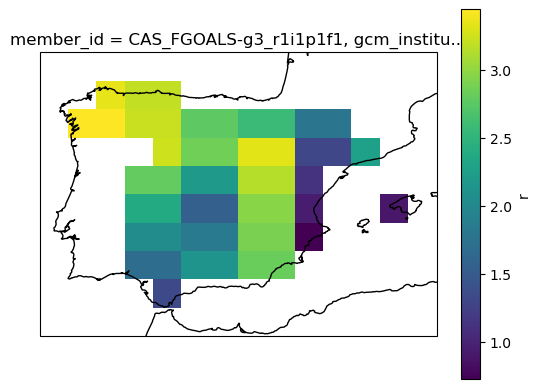

In [20]:
# mean spatial map for one member
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for lat/lon projections
filtered_ds[var].isel(member=0).mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

## Climatology and change
The **monthly_weighted_average** function calculates the monthly spatial mean of a dataset, weighted by the cosine of the latitude. This is a common approach to account for the varying size of grid cells at different latitudes, as areas near the poles have smaller grid cells than those near the equator. By applying this weighting, the function ensures that each grid cell contributes appropriately to the overall average, regardless of its geographical location.

#### a) Climatology

In [21]:
# calculate annual cycle (climatology)
mode = 'climatology'
period = slice('1/1/2081','31/12/2100')
annual_cycle_ds = monthly_weighted_average(filtered_ds, var, mode = mode)

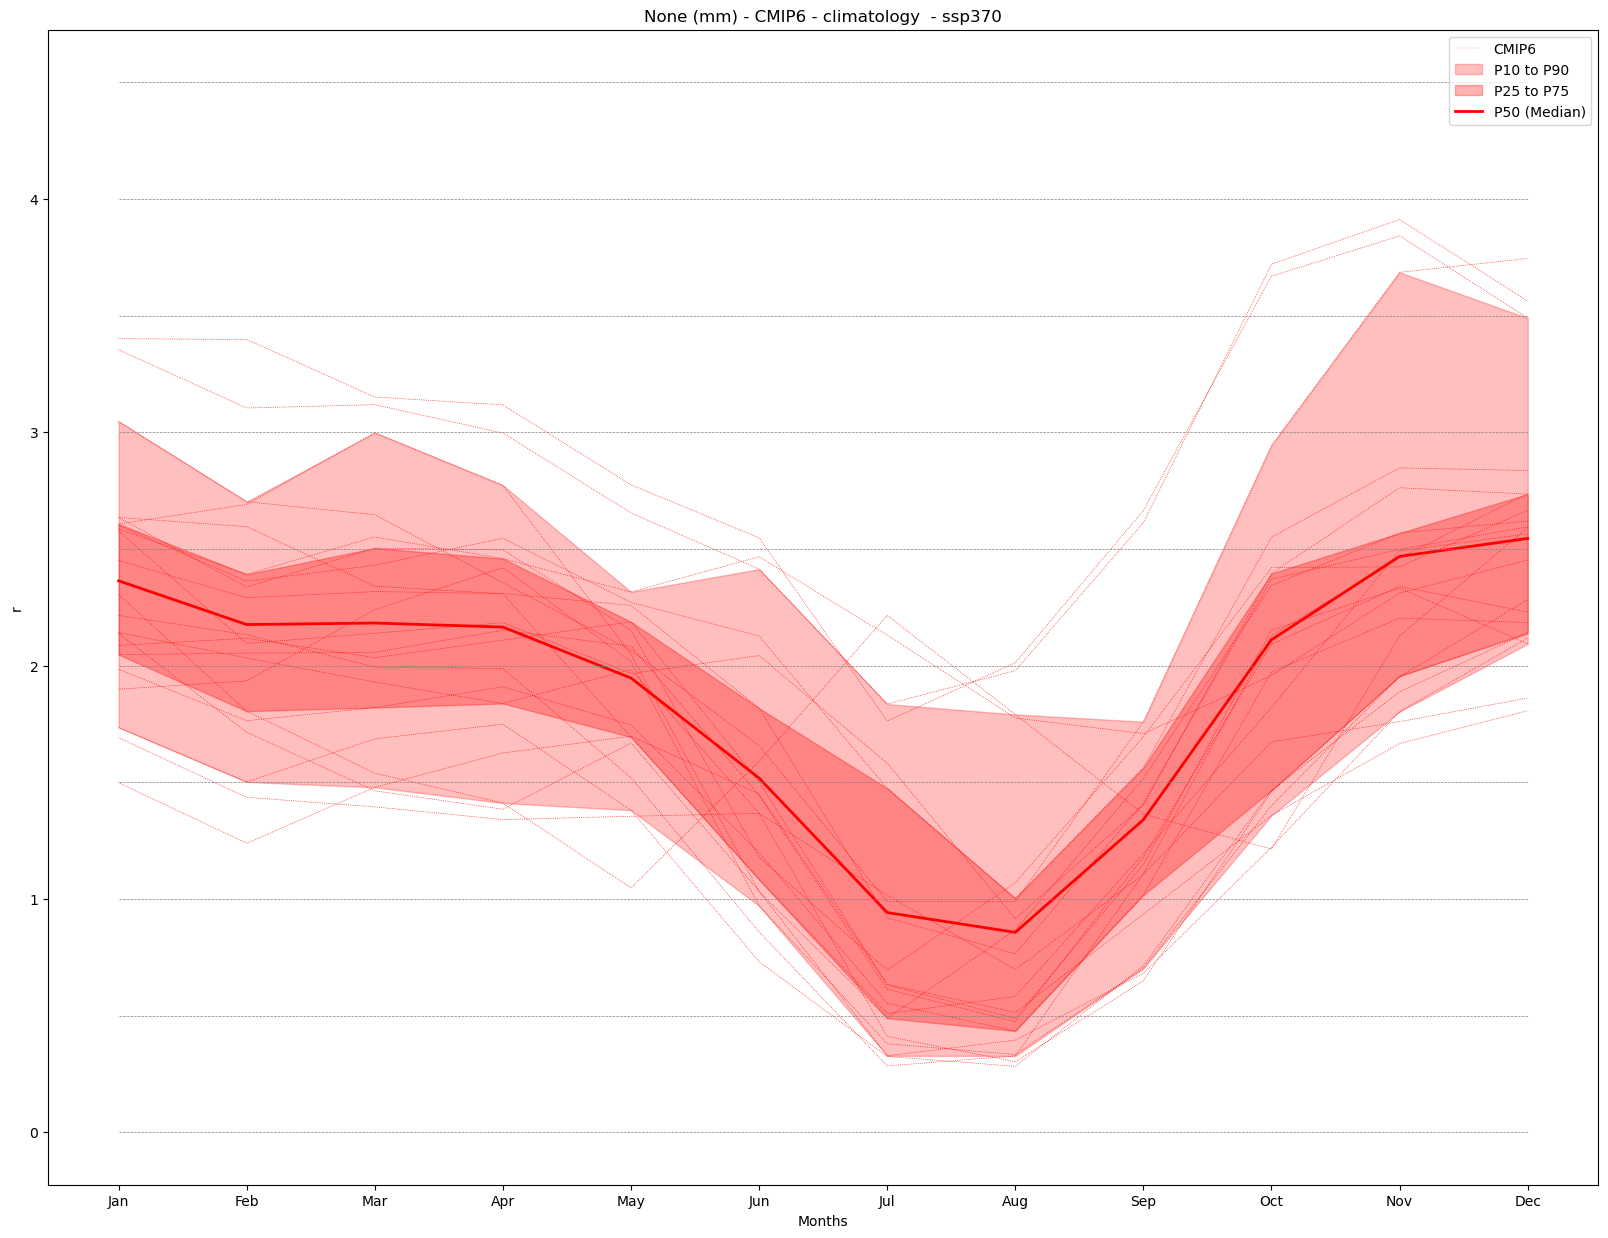

In [22]:
annual_cycle_plot = annual_cycle(annual_cycle_ds, var, attrs, mode = mode, period = period)

#### b) Absolute change

In [23]:
# calculate annual cycle (abs)
mode = 'change'
diff = 'abs'
period = slice('1/1/2081','31/12/2100')
baseline_period = slice('1/1/1981','31/12/2010')

In [24]:
annual_cycle_abs_ds = monthly_weighted_average(filtered_ds, var, mode = mode, diff = diff,
                                               baseline_period = baseline_period, period = period)

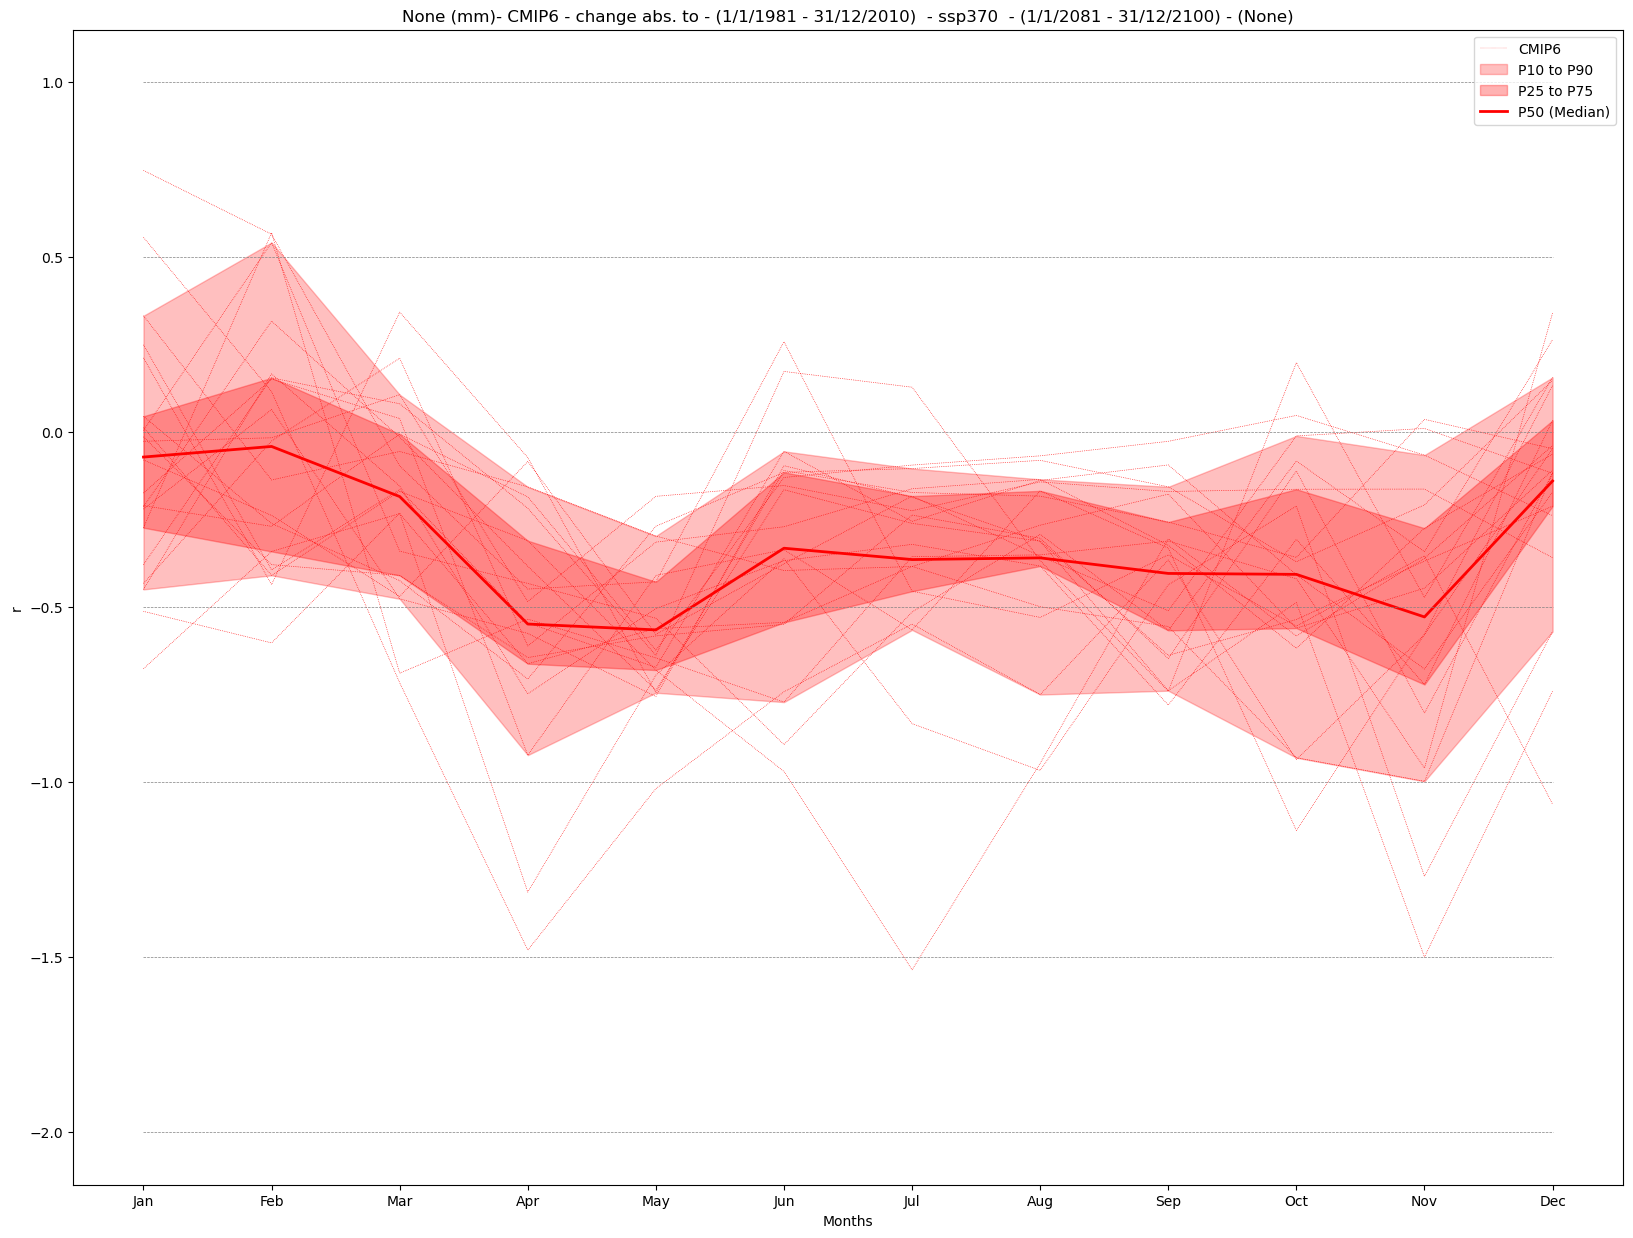

In [25]:
annual_cycle_plot = annual_cycle(annual_cycle_abs_ds, var, attrs, 
                                 mode = mode, diff = diff, 
                                 baseline_period = baseline_period, period = period)

#### c) Relative change

In [26]:
# calculate annual cycle (rel)
mode = 'change'
diff = 'rel'
period = slice('1/1/2081','31/12/2100')
baseline_period = slice('1/1/1981','31/12/2010')

In [27]:
annual_cycle_rel_ds = monthly_weighted_average(filtered_ds, var, mode = mode, diff = diff,
                                               baseline_period = baseline_period, period = period)

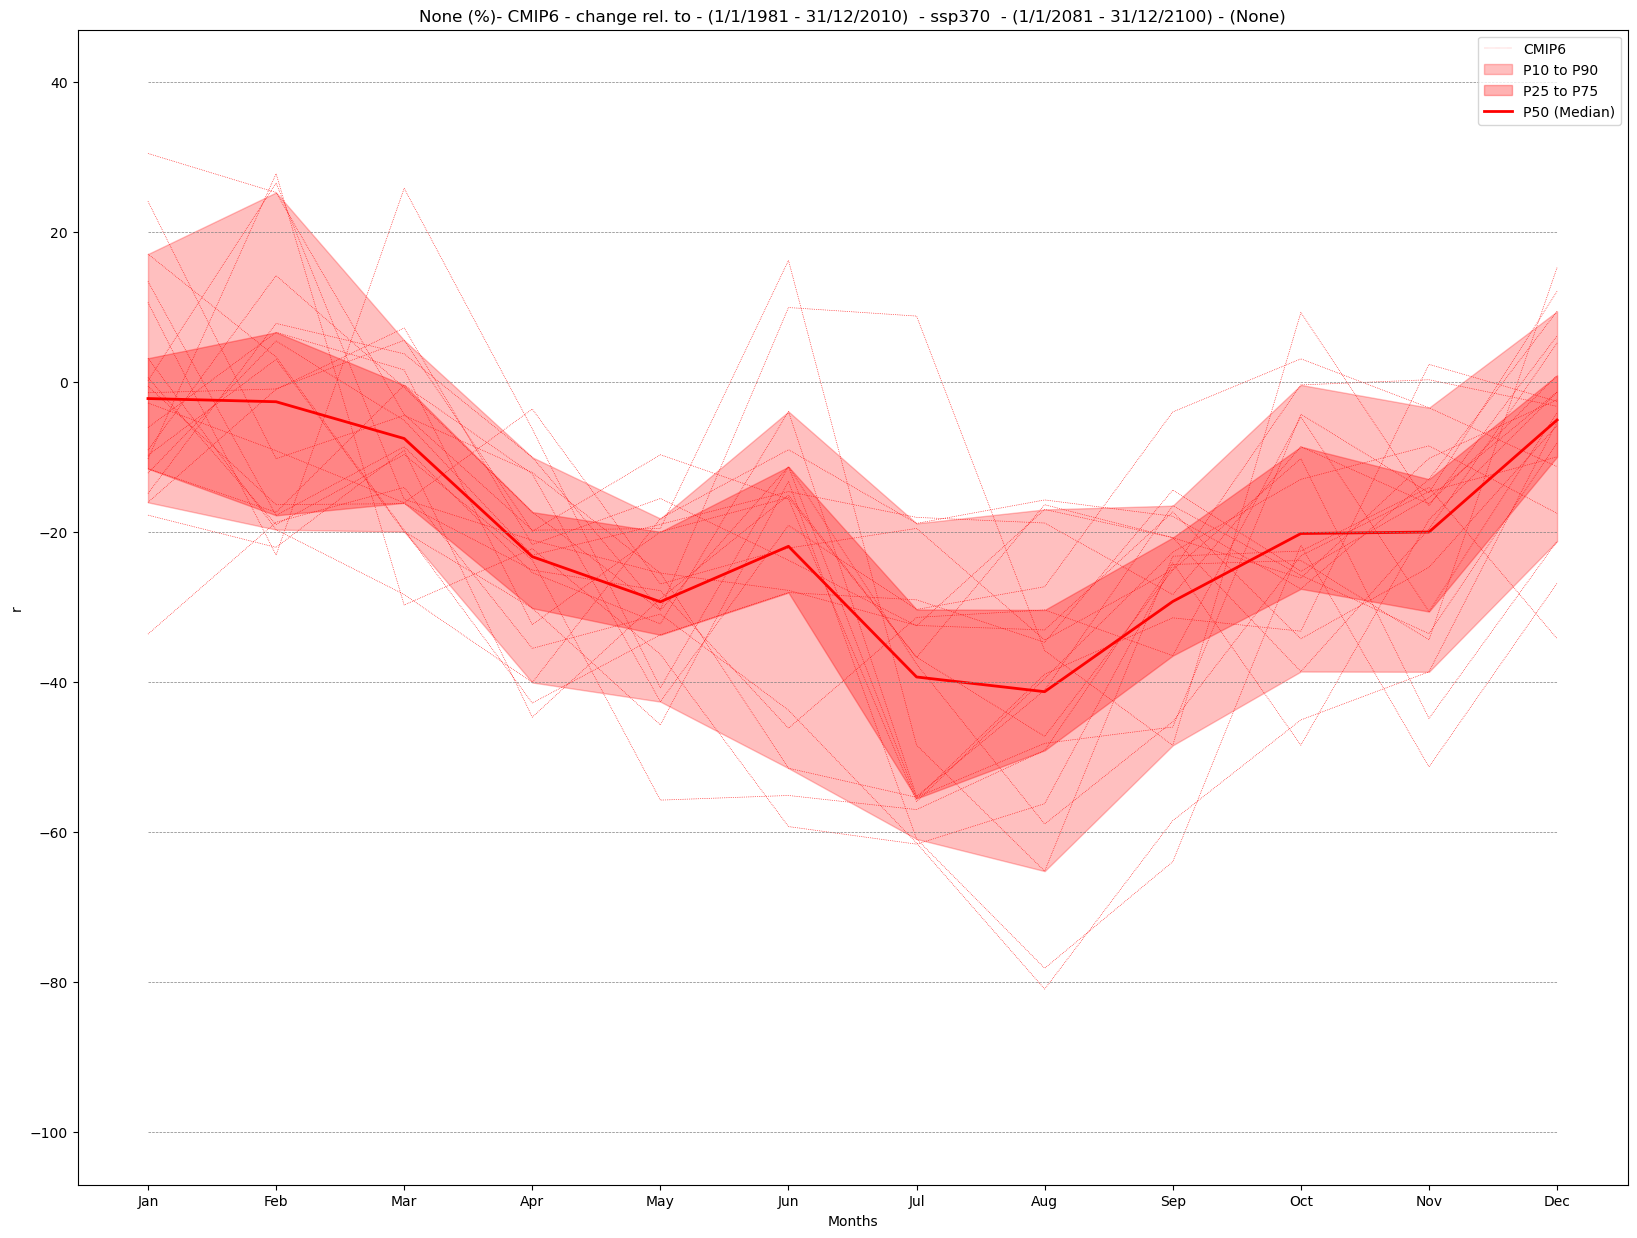

In [28]:
annual_cycle_plot = annual_cycle(annual_cycle_rel_ds, var, attrs, 
                                 mode = mode, diff = diff, 
                                 baseline_period = baseline_period, period = period)

## Global Warming Levels
Here, the annual cycle is displayed for a specific Global Warming Level (GWL). To achieve this, the 20-year period in which each ensemble member reaches the chosen GWL is selected. The annual cycle is then shown, representing either climatology or change for this specific period and region (Spain in this notebook).

These periods are calculated in the notebook [GWLs.ipynb](GWLs.ipynb) for CMIP5 and CMIP6. For CORDEX, the results from the driving CMIP5 models are used.

In [29]:
GWL = '4'
baseline_period = slice('1/1/1981','31/12/2010')

In [30]:
#Load the data and get the intersection of the members
GWLs_ds = load_GWLs(project)
GWLs_members_with_period = select_member_GWLs(filtered_ds, GWLs_ds, project, scenario, GWL)
[GWL_data, filtered_GWLs_ds] = get_mean_data_by_months(filtered_ds, GWLs_members_with_period)

#### Analysis and plot

In [31]:
mode = 'change'
diff = 'abs'
annual_cycle_GWLs = monthly_weighted_average(filtered_GWLs_ds, var, mode = mode, diff = diff, 
                                             baseline_period = baseline_period, ds_GWLs = GWL_data)

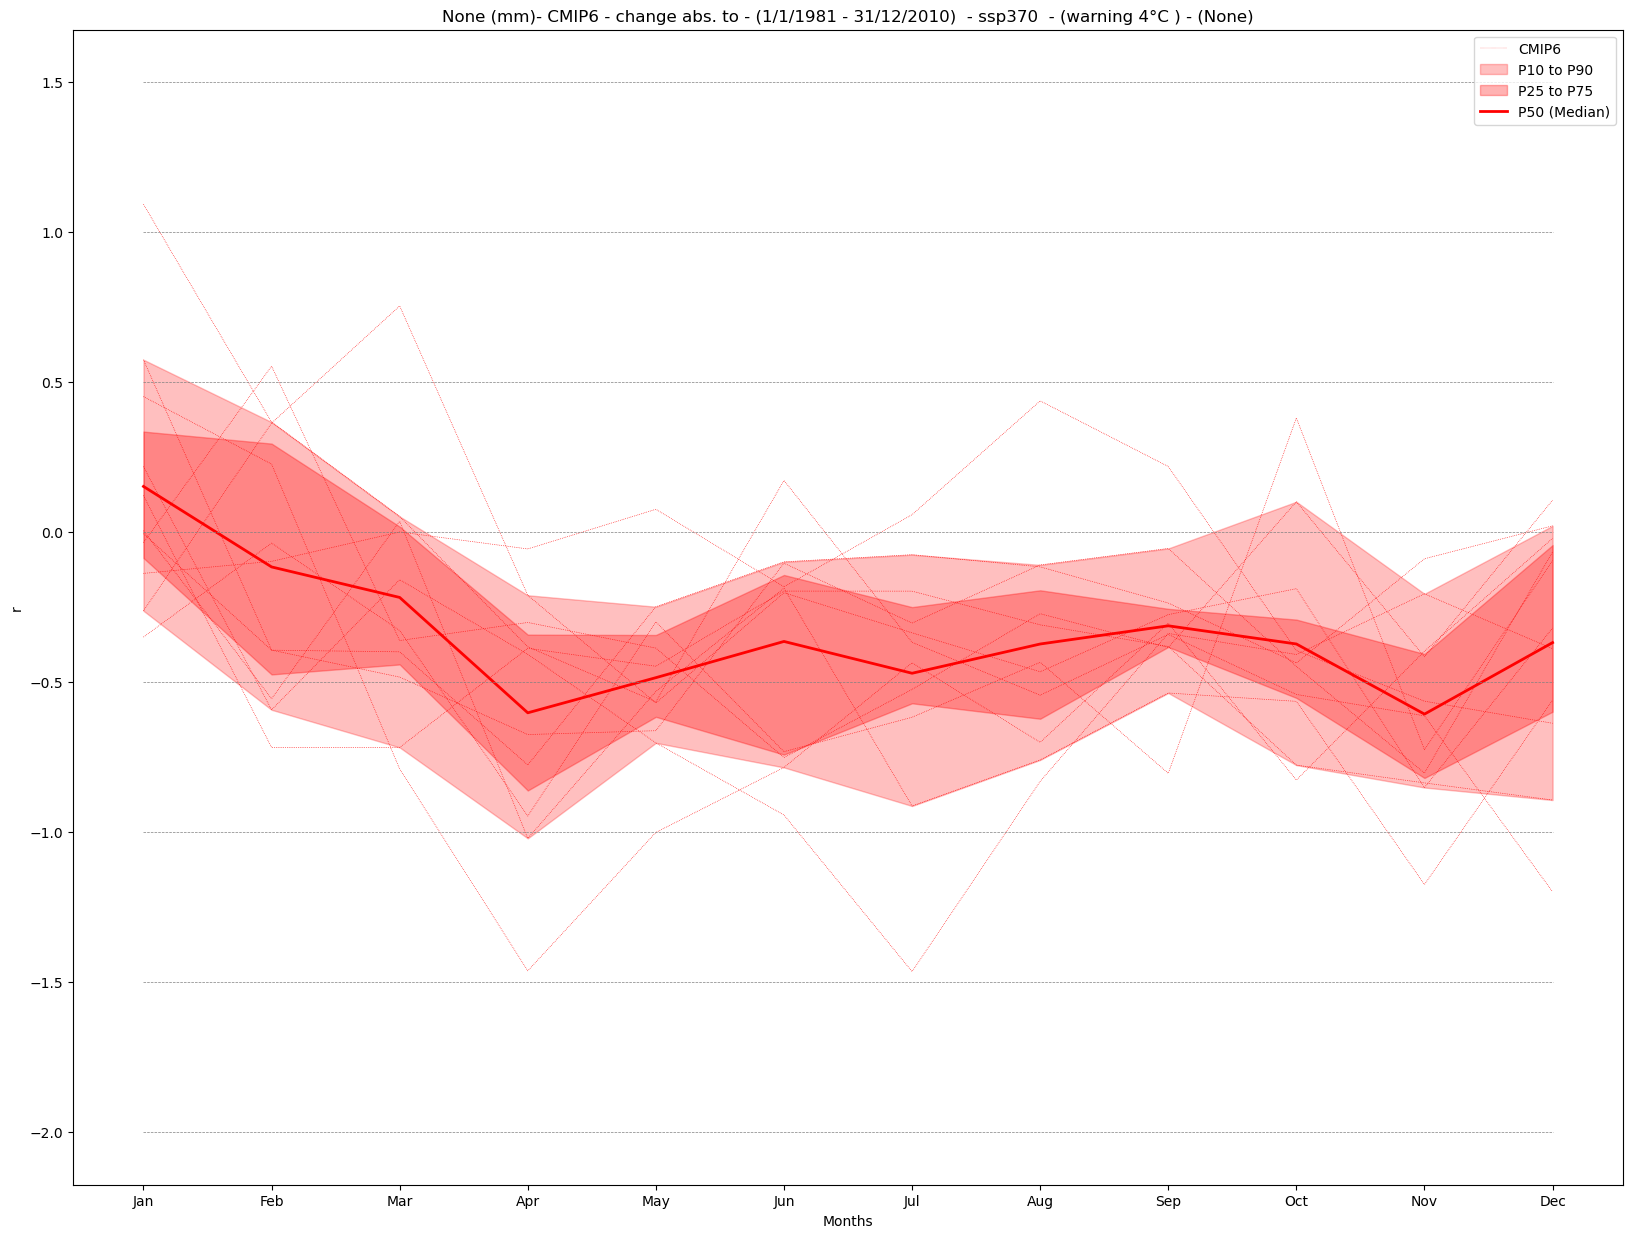

In [32]:
annual_cycle_plot = annual_cycle(annual_cycle_GWLs, var, attrs, mode = mode, diff = diff, 
                                 baseline_period = baseline_period, GWLs = GWL)